## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import pickle
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

## Create function for calibrating camera and returning undistorted image

In [2]:
# TODO: Write a function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

## Go through all test images, calibrate, and return undistorted images

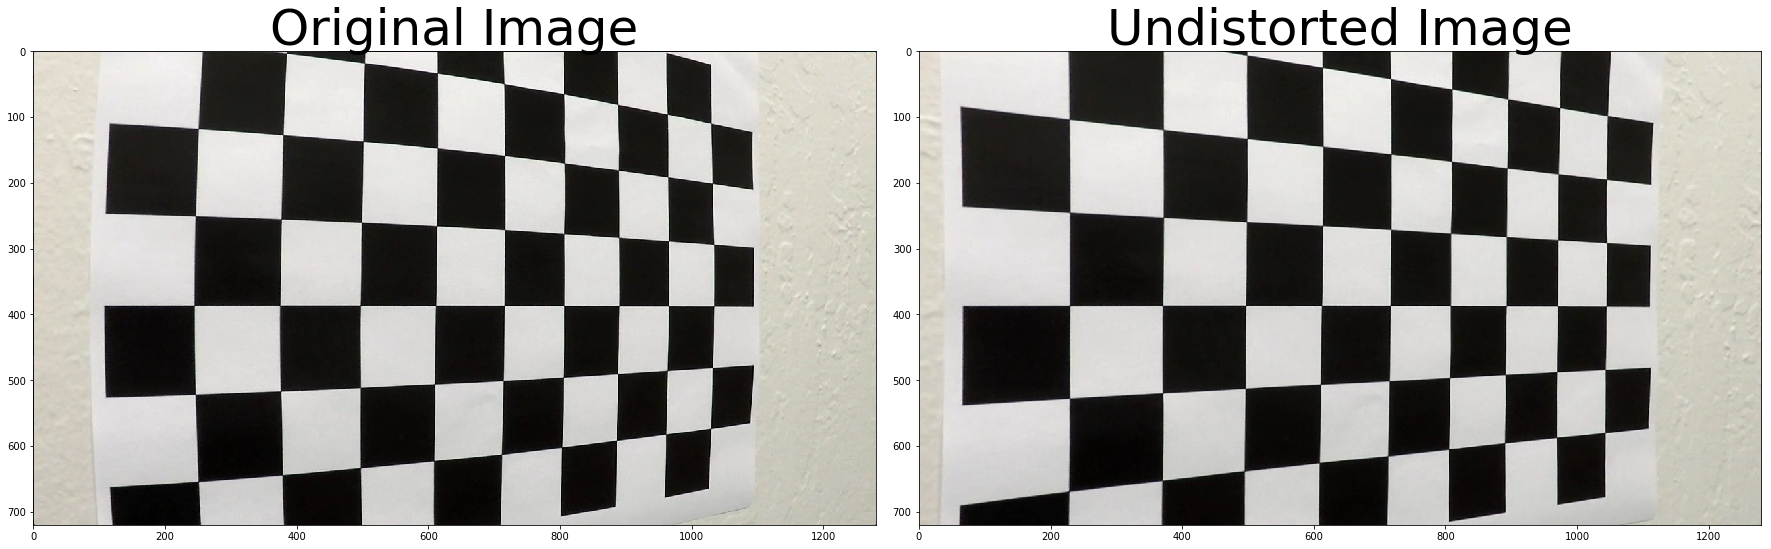

In [4]:
# Make a list of test images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for test images
for idx, fname in enumerate(images):
    if idx != 0:
        break
        
    img = cv2.imread(fname)
    
    img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    #Undistort image
    undistorted = cal_undistort(img_rgb, objpoints, imgpoints)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img_rgb)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(undistorted)
    ax2.set_title('Undistorted Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Save camera calibration object points and image points

In [4]:
pickle.dump({'objpoints':objpoints, 'imgpoints':imgpoints}, open('camera_calibration.p','wb'))

## Sobel Function

We know ahead of time that lanes lines tend to be verticle; so, we'll take advantage of this information in order to get a better gradient with fewer unwanted edges.

In [5]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

## Gradient Magnitude

In [6]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary_output

## Direction of Gradient

In [7]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    gray = gray[:,:,2]
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    # Return the binary image
    return binary_output

## HLS color selection

In [8]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [9]:
# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

## Start building my pipeline

In [10]:
# Step through the list and search for test images
for idx, fname in enumerate(images):
    if idx not in [5]:
        continue
       
    img = cv2.imread(fname)
    
    img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    undistorted = cal_undistort(img_rgb, objpoints, imgpoints)
    
    hls = cv2.cvtColor(undistorted, cv2.COLOR_RGB2HLS)
    
    # Extract white [H, L, S]
    whitemask = cv2.inRange(hls, (0, 200, 0), (255,255,255))
    
    # Extract yellow [H, L, S]
    yellowmask = cv2.inRange(hls, (20,25,100), (25, 225, 255))
    
    combined = np.zeros_like(undistorted)
    
    combined[((yellowmask==255) | (whitemask==255))] = 255
    
    # From Project 1
    vertices = np.array([[(0,undistorted.shape[0]),(550, 300), (730, 300), (undistorted.shape[1],undistorted.shape[0])]], dtype=np.int32)
    
    image_region = region_of_interest(combined, vertices)
    
    for i in range(5):
        if (i == 0):    
            # Plot the result
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
            f.tight_layout()
            ax1.imshow(img_rgb)
            ax1.set_title('Original Image', fontsize=50)
            ax2.imshow(undistorted)
            ax2.set_title('Undistorted Image', fontsize=50)
            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        elif (i == 1):
            # Plot the result
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
            f.tight_layout()
            ax1.imshow(undistorted, cmap='gray')
            ax1.set_title('Undistorted Image', fontsize=50)
            ax2.imshow(yellowmask, cmap='gray')
            ax2.set_title('Yellow Mask', fontsize=50)
            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        elif (i == 2):
            # Plot the result
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
            f.tight_layout()
            ax1.imshow(undistorted, cmap='gray')
            ax1.set_title('Undistorted Image', fontsize=50)
            ax2.imshow(whitemask, cmap='gray')
            ax2.set_title('White Mask', fontsize=50)
            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        elif (i == 3):
            # Plot the result
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
            f.tight_layout()
            ax1.imshow(undistorted, cmap='gray')
            ax1.set_title('Undistorted Image', fontsize=50)
            ax2.imshow(combined, cmap='gray')
            ax2.set_title('Combined Mask', fontsize=50)
            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        elif (i == 4):
            # Plot the result
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
            f.tight_layout()
            ax1.imshow(combined, cmap='gray')
            ax1.set_title('Combined Mask', fontsize=50)
            ax2.imshow(image_region, cmap='gray')
            ax2.set_title('Combined Mask with Region Mask', fontsize=50)
            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Perspective transform

In [11]:
def warp(img):
    img_size = (img.shape[1], img.shape[0])
    
    #print(img_size)
    
    #Four source coordinates
    src = np.float32(
        [[200,img_size[1]],
         [575,450],
         [750,450],
         [1200,img_size[1]]])
    
    dst = np.float32(
        [[320,img_size[1]],
         [210,0],
         [1300,0],
         [970,img_size[1]]])
    
    #Compute the perspective transform, M, given source and destination points
    M = cv2.getPerspectiveTransform(src, dst)
    
    #Compute the inverse perspective transform
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    #Warp an image using the perspective transform, M
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_AREA)
    
    return warped, M, Minv

In [12]:
img_straight = cv2.imread("test_images/straight_lines2.jpg")

img_rgb = cv2.cvtColor(img_straight,cv2.COLOR_BGR2RGB)

undistorted = cal_undistort(img_rgb, objpoints, imgpoints)

warped_img, _, _ = warp(undistorted)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_rgb)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped_img, cmap='gray')
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

error: /Users/jenkins/miniconda/1/x64/conda-bld/conda_1486587097465/work/opencv-3.1.0/modules/imgproc/src/color.cpp:7341: error: (-215) scn == 3 || scn == 4 in function ipp_cvtColor


In [13]:
# Step through the list and search for test images
for fname in images:
    img = cv2.imread(fname)
    
    img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    undistorted = cal_undistort(img_rgb, objpoints, imgpoints)

    warped_img,_,_ = warp(undistorted)
    
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img_rgb)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(warped_img, cmap='gray')
    ax2.set_title('Warped Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Undistort, Binary Threshold, Perspective Transform

In [14]:
# Step through the list and search for test images
for idx, fname in enumerate(images):
    if idx not in [5]:
        continue
       
    img = cv2.imread(fname)
    
    img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    undistorted = cal_undistort(img_rgb, objpoints, imgpoints)
    
    hls = cv2.cvtColor(undistorted, cv2.COLOR_RGB2HLS)
    
    # Extract white [H, L, S]
    whitemask = cv2.inRange(hls, (0, 200, 0), (255,255,255))
    
    # Extract yellow [H, L, S]
    yellowmask = cv2.inRange(hls, (20,25,100), (25, 225, 255))
    
    combined = np.zeros_like(undistorted)
    
    combined[((yellowmask==255) | (whitemask==255))] = 255
    
    # From Project 1
    vertices = np.array([[(0,undistorted.shape[0]),(550, 300), (730, 300), (undistorted.shape[1],undistorted.shape[0])]], dtype=np.int32)
    
    image_region = region_of_interest(combined, vertices)
    
    warped_img,_,_ = warp(image_region)
    
    for i in range(6):
        if (i == 0):    
            # Plot the result
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
            f.tight_layout()
            ax1.imshow(img_rgb)
            ax1.set_title('Original Image', fontsize=50)
            ax2.imshow(undistorted)
            ax2.set_title('Undistorted Image', fontsize=50)
            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        elif (i == 1):
            # Plot the result
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
            f.tight_layout()
            ax1.imshow(undistorted, cmap='gray')
            ax1.set_title('Undistorted Image', fontsize=50)
            ax2.imshow(yellowmask, cmap='gray')
            ax2.set_title('Yellow Mask', fontsize=50)
            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        elif (i == 2):
            # Plot the result
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
            f.tight_layout()
            ax1.imshow(undistorted, cmap='gray')
            ax1.set_title('Undistorted Image', fontsize=50)
            ax2.imshow(whitemask, cmap='gray')
            ax2.set_title('White Mask', fontsize=50)
            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        elif (i == 3):
            # Plot the result
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
            f.tight_layout()
            ax1.imshow(undistorted, cmap='gray')
            ax1.set_title('Undistorted Image', fontsize=50)
            ax2.imshow(combined, cmap='gray')
            ax2.set_title('Combined Mask', fontsize=50)
            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        elif (i == 4):
            # Plot the result
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
            f.tight_layout()
            ax1.imshow(combined, cmap='gray')
            ax1.set_title('Combined Mask', fontsize=50)
            ax2.imshow(image_region, cmap='gray')
            ax2.set_title('Combined Mask with Region Mask', fontsize=50)
            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        elif (i == 5):
            # Plot the result
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
            f.tight_layout()
            ax1.imshow(image_region)
            ax1.set_title('Combined Mask with Region Mask', fontsize=50)
            ax2.imshow(warped_img, cmap='gray')
            ax2.set_title('Warped Image', fontsize=50)
            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Image histogram

In [ ]:
def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

In [ ]:
# Step through the list and search for test images
for idx, fname in enumerate(images):
    if idx not in [5]:
        continue
       
    img = cv2.imread(fname)
    
    img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    undistorted = cal_undistort(img_rgb, objpoints, imgpoints)
    
    hls = cv2.cvtColor(undistorted, cv2.COLOR_RGB2HLS)
    
    # Extract white [H, L, S]
    whitemask = cv2.inRange(hls, (0, 200, 0), (255,255,255))
    
    # Extract yellow [H, L, S]
    yellowmask = cv2.inRange(hls, (20,25,100), (25, 225, 255))
    
    combined = np.zeros_like(undistorted)
    
    combined[((yellowmask==255) | (whitemask==255))] = 255
    
    # From Project 1
    vertices = np.array([[(0,undistorted.shape[0]),(550, 300), (730, 300), (undistorted.shape[1],undistorted.shape[0])]], dtype=np.int32)
    
    image_region = region_of_interest(combined, vertices)
    
    warped_img,_,_ = warp(image_region)
    
    histogram = hist(warped_img)
    
    for i in range(7):
        if (i == 0):    
            # Plot the result
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
            f.tight_layout()
            ax1.imshow(img_rgb)
            ax1.set_title('Original Image', fontsize=50)
            ax2.imshow(undistorted)
            ax2.set_title('Undistorted Image', fontsize=50)
            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        elif (i == 1):
            # Plot the result
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
            f.tight_layout()
            ax1.imshow(undistorted, cmap='gray')
            ax1.set_title('Undistorted Image', fontsize=50)
            ax2.imshow(yellowmask, cmap='gray')
            ax2.set_title('Yellow Mask', fontsize=50)
            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        elif (i == 2):
            # Plot the result
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
            f.tight_layout()
            ax1.imshow(undistorted, cmap='gray')
            ax1.set_title('Undistorted Image', fontsize=50)
            ax2.imshow(whitemask, cmap='gray')
            ax2.set_title('White Mask', fontsize=50)
            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        elif (i == 3):
            # Plot the result
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
            f.tight_layout()
            ax1.imshow(undistorted, cmap='gray')
            ax1.set_title('Undistorted Image', fontsize=50)
            ax2.imshow(combined, cmap='gray')
            ax2.set_title('Combined Mask', fontsize=50)
            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        elif (i == 4):
            # Plot the result
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
            f.tight_layout()
            ax1.imshow(combined, cmap='gray')
            ax1.set_title('Combined Mask', fontsize=50)
            ax2.imshow(image_region, cmap='gray')
            ax2.set_title('Combined Mask with Region Mask', fontsize=50)
            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        elif (i == 5):
            # Plot the result
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
            f.tight_layout()
            ax1.imshow(image_region)
            ax1.set_title('Combined Mask with Region Mask', fontsize=50)
            ax2.imshow(warped_img, cmap='gray')
            ax2.set_title('Warped Image', fontsize=50)
            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        elif (i == 6):
            # Plot the result
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
            f.tight_layout()
            ax1.imshow(warped_img, cmap='gray')
            ax1.set_title('Warped Image', fontsize=50)
            ax2.plot(histogram)
            ax2.set_title('Histogram', fontsize=50)
            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Find lane pixels using sliding windows

In [ ]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
        
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fitx, right_fitx, ploty

In [ ]:
# Step through the list and search for test images
for idx, fname in enumerate(images):
    if idx not in [5]:
        continue
        
    img = cv2.imread(fname)
    
    img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    undistorted = cal_undistort(img_rgb, objpoints, imgpoints)
    
    hls = cv2.cvtColor(undistorted, cv2.COLOR_RGB2HLS)
    
    # Extract white [H, L, S]
    whitemask = cv2.inRange(hls, np.array([0, 200, 0]), np.array([255,255,255]))
    
    # Extract yellow [H, L, S]
    yellowmask = cv2.inRange(hls, np.array([20,25,100]), np.array([25, 225, 255]))
    
    combined = np.zeros_like(whitemask)
    combined[((whitemask == 255) | (yellowmask == 255))] = 255

    # Warp this binary image
    warped_img, M, Minv = warp(combined)
    
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(warped_img, cmap='gray')
    ax1.set_title('Warped Image', fontsize=50)
    
    # Find our lane lines and return fitted polynomials
    out_img, left_fitx, right_fitx, ploty = fit_polynomial(warped_img)
    ax2.imshow(out_img)
    ax2.set_title('Sliding Windows', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Convolve sliding windows

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2

# Read in a thresholded image
warped = mpimg.imread('examples/warped_example.jpg')

# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids


window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255  
    
    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()

## Measuring Curvature

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [ ]:
import numpy as np

def generate_data(ym_per_pix, xm_per_pix):
    '''
    Generates fake data to use for calculating lane curvature.
    In your own project, you'll ignore this function and instead
    feed in the output of your lane detection algorithm to
    the lane curvature calculation.
    '''
    # Set random seed number so results are consistent for grader
    # Comment this out if you'd like to see results on different random data!
    np.random.seed(0)
    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    return ploty, left_fit_cr, right_fit_cr

    
def measure_curvature_real():
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    ploty, left_fit_cr, right_fit_cr = generate_data(ym_per_pix, xm_per_pix)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = (1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1])**2)**(3/2) / np.abs(2 * left_fit_cr[0])
    right_curverad = (1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1])**2)**(3/2) / np.abs(2 * right_fit_cr[0])
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad = measure_curvature_real()

print(left_curverad, 'm', right_curverad, 'm')
# Should see values of 533.75 and 648.16 here, if using
# the default `generate_data` function with given seed number